**Note: Please make your own copy of this notebook to run and execute, thank you!**

1.   Go to the menu tab on the top left corner
2.   Click on "File"
3.   Under the File tab menu click on "Save a copy in Drive..."

## Tip for running multiple code cells
A useful tool when running code in Colaboratory is the **Runtime tab**. Clicking on this tab will open a menu with various options that will allow you to run multiple code cells simultaneously. For example, "Run before" will run all the code cells before the currently selected cell in order starting with the first. This is particularly helpful if you run into an error while editing your code and you want to ensure all the variables and data have been initialized properly prior to the cell you're working on.

# Load libraries and dataset

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import tensor_shape
import keras
from keras.datasets import mnist
from keras.optimizers import SGD
from keras.utils import print_summary, to_categorical
from google.colab import files

Using TensorFlow backend.


[MNIST Dataset:](http://yann.lecun.com/exdb/mnist/)

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set for evaluation purposes of 10,000. It is a subset of a larger set available from NIST. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

Split our data into features, labels, training, and testing data.

In [0]:
# Load the MNIST dataset from Keras
# Split dataset into testing, traing, features, and labels
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


# Exploratory Analysis

Now let's take a look at the size, shape, and dimensions of our intial data.

In [0]:
# Display the size and shape of features, labels, training, and testing datasets
print("Size and shape of the training features are (training data size, image width, image height): {}".format(x_train.shape))
print("Size and shape of the training labels are (training data size): {}".format(y_train.shape))
print("Size and shape of the testing features are (testing data size, image width, image height): {}".format(x_test.shape))
print("Size and shape of the testing labels are (testing data size): {}".format(y_test.shape))

Size and shape of the training features are (training data size, image width, image height): (60000, 28, 28)
Size and shape of the training labels are (training data size): (60000,)
Size and shape of the testing features are (testing data size, image width, image height): (10000, 28, 28)
Size and shape of the testing labels are (testing data size): (10000,)


In case you are interested in looking at individual images from the dataset, run the snippet of code below. You can change the index from 9 to another index number within the training data to see what image shows up that will be fed to our network.

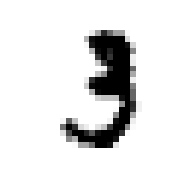

In [0]:
# This samples the 9-th image from the training dataset.
index = 10 # feel free to change this index value to see another image
image = x_train[index].reshape(28,28)

# Use the matplotlib library to display the image and its label (do not modify)
plt.figure(figsize=(3,3)) # Initialize the size of the plot frame
plt.imshow(image); plt.grid('off');plt.axis('off') # Feed image values to plot
plt.show() # Generate plot onto screen

# Data Preprocessing

Normally when dealing with real-world data it does not come perfectly packaged and ready to use by our models. In order to properly train them, we need to let it know the number of classes we need to label, what they are, and how the model should output its predictions.

Since we have ten image classes, we don't want a single prediction. Instead we ideally would like the model to predict how ***confident*** the image fits between all ten image classes (not just the single best prediction) between 0 and 1 where all prediction values must add up to 1.

To do this we'll use one-hot encodings. One-hot encodings allow us to format our labels so the model can distinguish an image between all the available classes. For instance if we have three images classes - 'man', 'woman', 'dog' - we would have a label with three elements. If an image is a dog the label would be formatted as [0,0,1] since it is not a man or woman. Our model will then to output a list of probablities for each class label that all add up to 1, but if modeled correctly will have a very high probability on the correct label.

In [0]:
# Specify the number of class labels in our data
num_classes = 10

# Keep original labels
labels_test = y_test

# Labels are stored as unique integers
# Convert labels into unique one-hot encodings of length num_class
# Each label will then be converted to a series of zeros with one unique column containing a one for a unique label
# example 10000000000 or 0001000000, etc (don't worry if you are not familiar with this step)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

If we take a closer look at our images, we can see the pixel values range from 0-255. These value ranges give us a bunch of gray values to quantify how 'black' or 'white' the pixel is. These seem like an arbitrary scale for our models to understand. For instance, imagine if you were given a grade of 34 for a history class, 56 for math, and 46 for English Literature. Each of these grades has a specific meaning for each course, but without context would be hard for you to understand. This is why we convert absolute values into a relative standing such as letter grades scored between 0-100. Just like humans, neural networks have a hard time understanding relative values, so we want convert our pixel values into a range from 0-1, thus making it easier for the network to learn.

In [0]:
# Our input data is pixels from images where each pixel value is between ranges 0-255
# Range of values make it difficult for our network to learn
# Convert raw pixel values into values between 0-1
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')
x_train /= 250.0
x_test /= 250.0

In [0]:
# Display the size and shape of features, labels, training, and testing datasets
print("Size and shape of the training features are (training data size, image width, image height, image color depth): {}".format(x_train.shape))
print("Size and shape of the training labels are (training data label size, number of class labels): {}".format(y_train.shape))
print("Size and shape of the testing features are (test data size, image width, image height, image color depth): {}".format(x_test.shape))
print("Size and shape of the testing labels are (test data size, number of class labels): {}".format(y_test.shape))

Size and shape of the training features are (training data size, image width, image height, image color depth): (60000, 28, 28, 1)
Size and shape of the training labels are (training data label size, number of class labels): (60000, 10)
Size and shape of the testing features are (test data size, image width, image height, image color depth): (10000, 28, 28, 1)
Size and shape of the testing labels are (test data size, number of class labels): (10000, 10)


# Model Building

In our next step, we are going to create a couple of advanced neural network layers to include a bunch of tensorflow subroutines and techniques. If you have not heard of some of the terms used in this notebook such as convolutions, maxpooling, or softmax, don't worry as you are not expected to know what these functions do yet! Instead we are going to abstract away these advanced techniques so you can focus on the much bigger picture - how an image recognition system might be built and how the number of neurons and layers effect our model's training and performance.

In [0]:
# Convolutional Neural Network with MaxPooling Layer Wrapper
class ConvMaxLayer(tf.keras.Model):
  
    # Initialize our variables
    def __init__(self, filters, dropout_rate):
        super(ConvMaxLayer, self).__init__()
        self.filters = filters
        self.kernel_size = 3
        self.conv_stride = 1
        self.padding = 'valid'
        self.pad_size = 0
        self.pool_size = 2
        self.maxpool_stride = 2
        self.dropout_rate = dropout_rate
        
    # Define our layers
    def build(self, input_shape):
        self.conv2D = tf.keras.layers.Conv2D(filters=self.filters, kernel_size=self.kernel_size, strides=self.conv_stride, padding=self.padding, input_shape=input_shape)
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=self.pool_size, strides=self.maxpool_stride, padding=self.padding)
        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)

    # Computation of network layers
    def call(self, inputs):
        x = self.conv2D(inputs)
        x = self.batchnorm(x, training=True)
        x = tf.nn.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        return (x)
    
    # Define output shape
    def compute_output_shape(self, input_shape):
      # Input Dimensions
      w1 = input_shape[1] # Width
      h1 = input_shape[2] # Height
      d1 = input_shape[3] # Depth
      
      # Convolution Hyperparameters
      k1 = self.filters # number of filters
      f1 = self.kernel_size # spatial extent
      s1 = self.conv_stride # strides
      p1 = self.pad_size # padding
      
      # Convolution Output Dimensions
      w2 = (int(w1 - f1 + 2*p1)/s1) + 1
      h2 = (int(h1 - f1 + 2*p1)/s1) + 1
      d2 = k1
      
      # Maxpooling Dimensions Hyperparameters
      f2 = self.pool_size
      s2 = self.maxpool_stride
      
      # Maxpooling Output Dimensions
      w3 = int(((w2 - f2)/s2) + 1)
      h3 = int(((h2 - f2)/s2) + 1)
      d3 = d2
      return (input_shape[0], w3, h3, d3)

In [0]:
# Forward-Feed Neural Network Layer
class ForwardLayer(tf.keras.Model):
  
    # Initialize our variables
    def __init__(self, size, dropout_rate):
        super(ForwardLayer, self).__init__()
        self.size = size
        self.dropout_rate = dropout_rate
        
    # Define our layers
    def build(self, input_shape):
        self.dense = tf.keras.layers.Dense(self.size, input_shape=input_shape)
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)
    
    # Computation of network layers
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.batchnorm(x)
        x = tf.nn.relu(x)
        x = self.dropout(x)
        return x
      
    # Define output shape
    def compute_output_shape(self, input_shape):
      return (input_shape[0], self.size)

Now that we have abstracted away some details of tensorflow, we can outline and define our image recognition network by adding one layer at a time.

In [0]:
# Initialize our network object
net = tf.keras.Sequential()

# Layer One (Convolutional MaxPooling Layer)
net.add(ConvMaxLayer(filters=32, dropout_rate=0.3))

# Layer Two (Convolutional MaxPooling Layer)
net.add(ConvMaxLayer(filters=64, dropout_rate=0.3))

# Flatten (to make it easier for the output of layer two to transition into layer three)
net.add(tf.keras.layers.Flatten())

# Layer Three (Forward-feed Layer)
net.add(ForwardLayer(64, 0.1))

# Layer Four (Forward-feed Layer)
net.add(ForwardLayer(32, 0))

# Output Layer
net.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

Now that you have your model defined, we'll need to actually build it and define how it will learn. To do so, we'll need to call the network's compile function to provide it the loss, optimization, and metric parameters.

In [0]:
# Compiles our model with the specified loss, optimization, and metric parameters
net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print('Model is done compiling!')

Model is done compiling!


# Train Model

Our next step is to define the batch size and number of epochs to train before we call the network's fit procedure with all our data and training parameters listed below. 

The batch size refers to how many samples (in this case, samples = images) are processed by the model before the internal weights are updated. Naturally, this means the batch size will be anywhere between 1 (just one sample) and the size of the training set (all the samples in the training set). It is generally advantageous to set the batch size to a relatively small value such as 32 or 64 since that limits how much memory we use on each iteration. That is, we only load a handful of images at a time rather than all of them at once. 

"Epoch" is simply another word for iteration. The more epochs we run, the more the model is able to train and (hopefully) the lower the error rate will be. Of course, training takes time, so for this project we'll limit the number of epochs to a fairly small number. In real applications, however, the number of epochs is often in the hundreds or thousands.

In [0]:
# Define our learning parameters and feed data towards our model for training
net.fit(x_train, y_train, batch_size=32, epochs=3, validation_split=0.2, shuffle=True)
net.summary()

Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 140s 3ms/step - loss: 0.1553 - acc: 0.9523 - val_loss: 0.0677 - val_acc: 0.9797
Epoch 2/3
48000/48000 [==============================] - 139s 3ms/step - loss: 0.0585 - acc: 0.9819 - val_loss: 0.0522 - val_acc: 0.9850
Epoch 3/3
48000/48000 [==============================] - 144s 3ms/step - loss: 0.0439 - acc: 0.9862 - val_loss: 0.0621 - val_acc: 0.9832
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_max_layer (ConvMaxLayer multiple                  448       
_________________________________________________________________
conv_max_layer_1 (ConvMaxLay multiple                  18752     
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
forward_lay

# Test Model Performance

Now that we trained our model here is the moment of truth. A model that only performs well on training data is not a very good model! Let's see how well the model does on testing data to get an idea of how it might perform out in the wild. 

In [0]:
# Use the networks evaluate function to see how well the model predicts the correct labels on the testing dataset
scores = net.evaluate(x_test, y_test, verbose=0)

# Report the final accuracy score
print('Test Loss:', scores[0])
print('Test accuracy:', scores[1])

# Applications

Alright let's see how our final model does on some individual digits!

In [0]:
# Create plot and parameters to layout our images and predictions
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

num = 3
margin = 0.05
ind = np.arange(len(labels))
width = (1. - 2. * margin) / num

fig, ax = plt.subplots(nrows=num, ncols=2)
fig.tight_layout()
fig.suptitle('Image Predictions', fontsize=20, y=1.1)

# Loop through each image to plot and make a prediction
for i in range(num):
  image = x_test[i]
  label = labels_test[i]
  x = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
  pred = net.predict(x, batch_size=None, verbose=0, steps=None).flatten()

  # Display image and correct label
  ax[i][0].imshow(image.squeeze())
  ax[i][0].set_title("Correct Label: {}".format(label))
  ax[i][0].set_axis_off()
  
  # Display the predicted confidence in each label
  ax[i][1].barh(ind + margin, pred, width)
  ax[i][1].set_yticks(ind + margin)
  ax[i][1].set_yticklabels(labels)

**Interactive Demo:**

Interested to see an interactive tool for digit recognition models? click on this [link](http://scs.ryerson.ca/~aharley/vis/fc/) to draw a digit and see how well a neural network guesses the correct answer!

# Save Model

Now that we are done with the demo feel free to save your model weights in case you decided you want to use them later. By downloading the h5 file we can use it at a later time to reload the weights instead of having to retrain from scratch! We'll show you in the next mini-project how to load a pre-trained model so stay tuned!

In [0]:
# Saves your trained model for use later
net.save_weights('final_mnist_weights.h5') # Saves just the weights (like we did earlier)

In [0]:
# Download the files to local computer drive
files.download('final_mnist_weights.h5')

**Reflections:**
*   What might be a good reason to save the weights of our network?
*   If we reload the weights into a new model what do you think the model performance should be?
*   What if we continue to train the model?


